# Model 1 training 


## Before your running

- Open GPU on Colab. Click `Runtime` -> `change runtime type`-> `select GPU`
- Model 1's mask rcnn is runned on detectron2 platform for training. For more details,  please read detectron2 [repo](https://github.com/facebookresearch/detectron2), [tutorial notebook](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5),[documentation](https://detectron2.readthedocs.io/en/latest/)

## Trained weight of the model
- The trained model weight is saved at `./output/`

# Install detectron2

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
!gcc --version
!pip install gdown
# opencv is pre-installed on colab

# install detectron2: (Colab has CUDA 10.2 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install torch==1.8.0 torchvision==0.9.0 torchaudio==0.8.0
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.8/index.html


     |█▏                              | 10 kB 39.2 MB/s eta 0:00:01
     |██▍                             | 20 kB 25.4 MB/s eta 0:00:01
     |███▋                            | 30 kB 18.0 MB/s eta 0:00:01
     |████▉                           | 40 kB 16.1 MB/s eta 0:00:01
     |██████                          | 51 kB 7.3 MB/s eta 0:00:01
     |███████▏                        | 61 kB 8.5 MB/s eta 0:00:01
     |████████▍                       | 71 kB 8.0 MB/s eta 0:00:01
     |█████████▋                      | 81 kB 9.0 MB/s eta 0:00:01
     |██████████▊                     | 92 kB 9.7 MB/s eta 0:00:01
     |████████████                    | 102 kB 7.7 MB/s eta 0:00:01
     |█████████████▏                  | 112 kB 7.7 MB/s eta 0:00:01
     |██████████████▍                 | 122 kB 7.7 MB/s eta 0:00:01
     |███████████████▌                | 133 kB 7.7 MB/s eta 0:00:01
     |████████████████▊               | 143 kB 7.7 MB/s eta 0:00:01
     |██████████████████              | 153 kB 7.7 M

In [1]:
import torch, torchvision
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version

In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

/home/facades/projects/buildings_segmentation_detection/.venv/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


# Train on a building dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use our building image dataset
which only has two class: opening and building.

We'll train a builiding and opening segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.

Note that COCO dataset does not have the "building" and "opening" category. We'll be able to recognize this new class in a few minutes.

## Prepare the dataset

In our mdel, **we predict two class "building" and "opening"**.

In [ ]:
# Download buildings imgs data(traning set and val set) from github
! git clone https://github.com/luoyaxiong/final.git  /content/project

Cloning into '/content/dataset'...
remote: Enumerating objects: 2151, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 2151 (delta 4), reused 14 (delta 4), pack-reused 2137
Receiving objects: 100% (2151/2151), 1.80 GiB | 27.32 MiB/s, done.
Resolving deltas: 100% (195/195), done.
Checking out files: 100% (1554/1554), done.


In [5]:
# address of building dataset
DATASET_ADDRESS = '/home/facades/projects/buildings_segmentation_detection/code/data'

Register the building dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. User should write such a function when using a dataset in custom format. See the tutorial for more details.


In [6]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode

def get_building_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []

    # here we set 'masonry', 'm6', 'rcw' as a same class 'building'
    dict_category_id = {
      'opening':0,
      'masonry':1,
      'm6':1,
      'rcw':1
    }
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        # since we use VIA 2.0 tool， annos is a list not a set
        for idx, anno in enumerate(annos):

            # assert not anno["region_attributes"]
            #  record category_id
            category_id = dict_category_id[anno["region_attributes"]['class_name']]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": category_id,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


In [7]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode

def get_building_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []

    # here we set 'masonry', 'm6', 'rcw' as a same class 'building'
    dict_category_id = {
      'opening':0,
      'masonry':1,
      'm6':1,
      'rcw':1
    }
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        # since we use VIA 2.0 tool， annos is a list not a set
        for idx, anno in enumerate(annos):

            # assert not anno["region_attributes"]
            #  record category_id
            category_id = dict_category_id[anno["region_attributes"]['class_name']]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": category_id,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



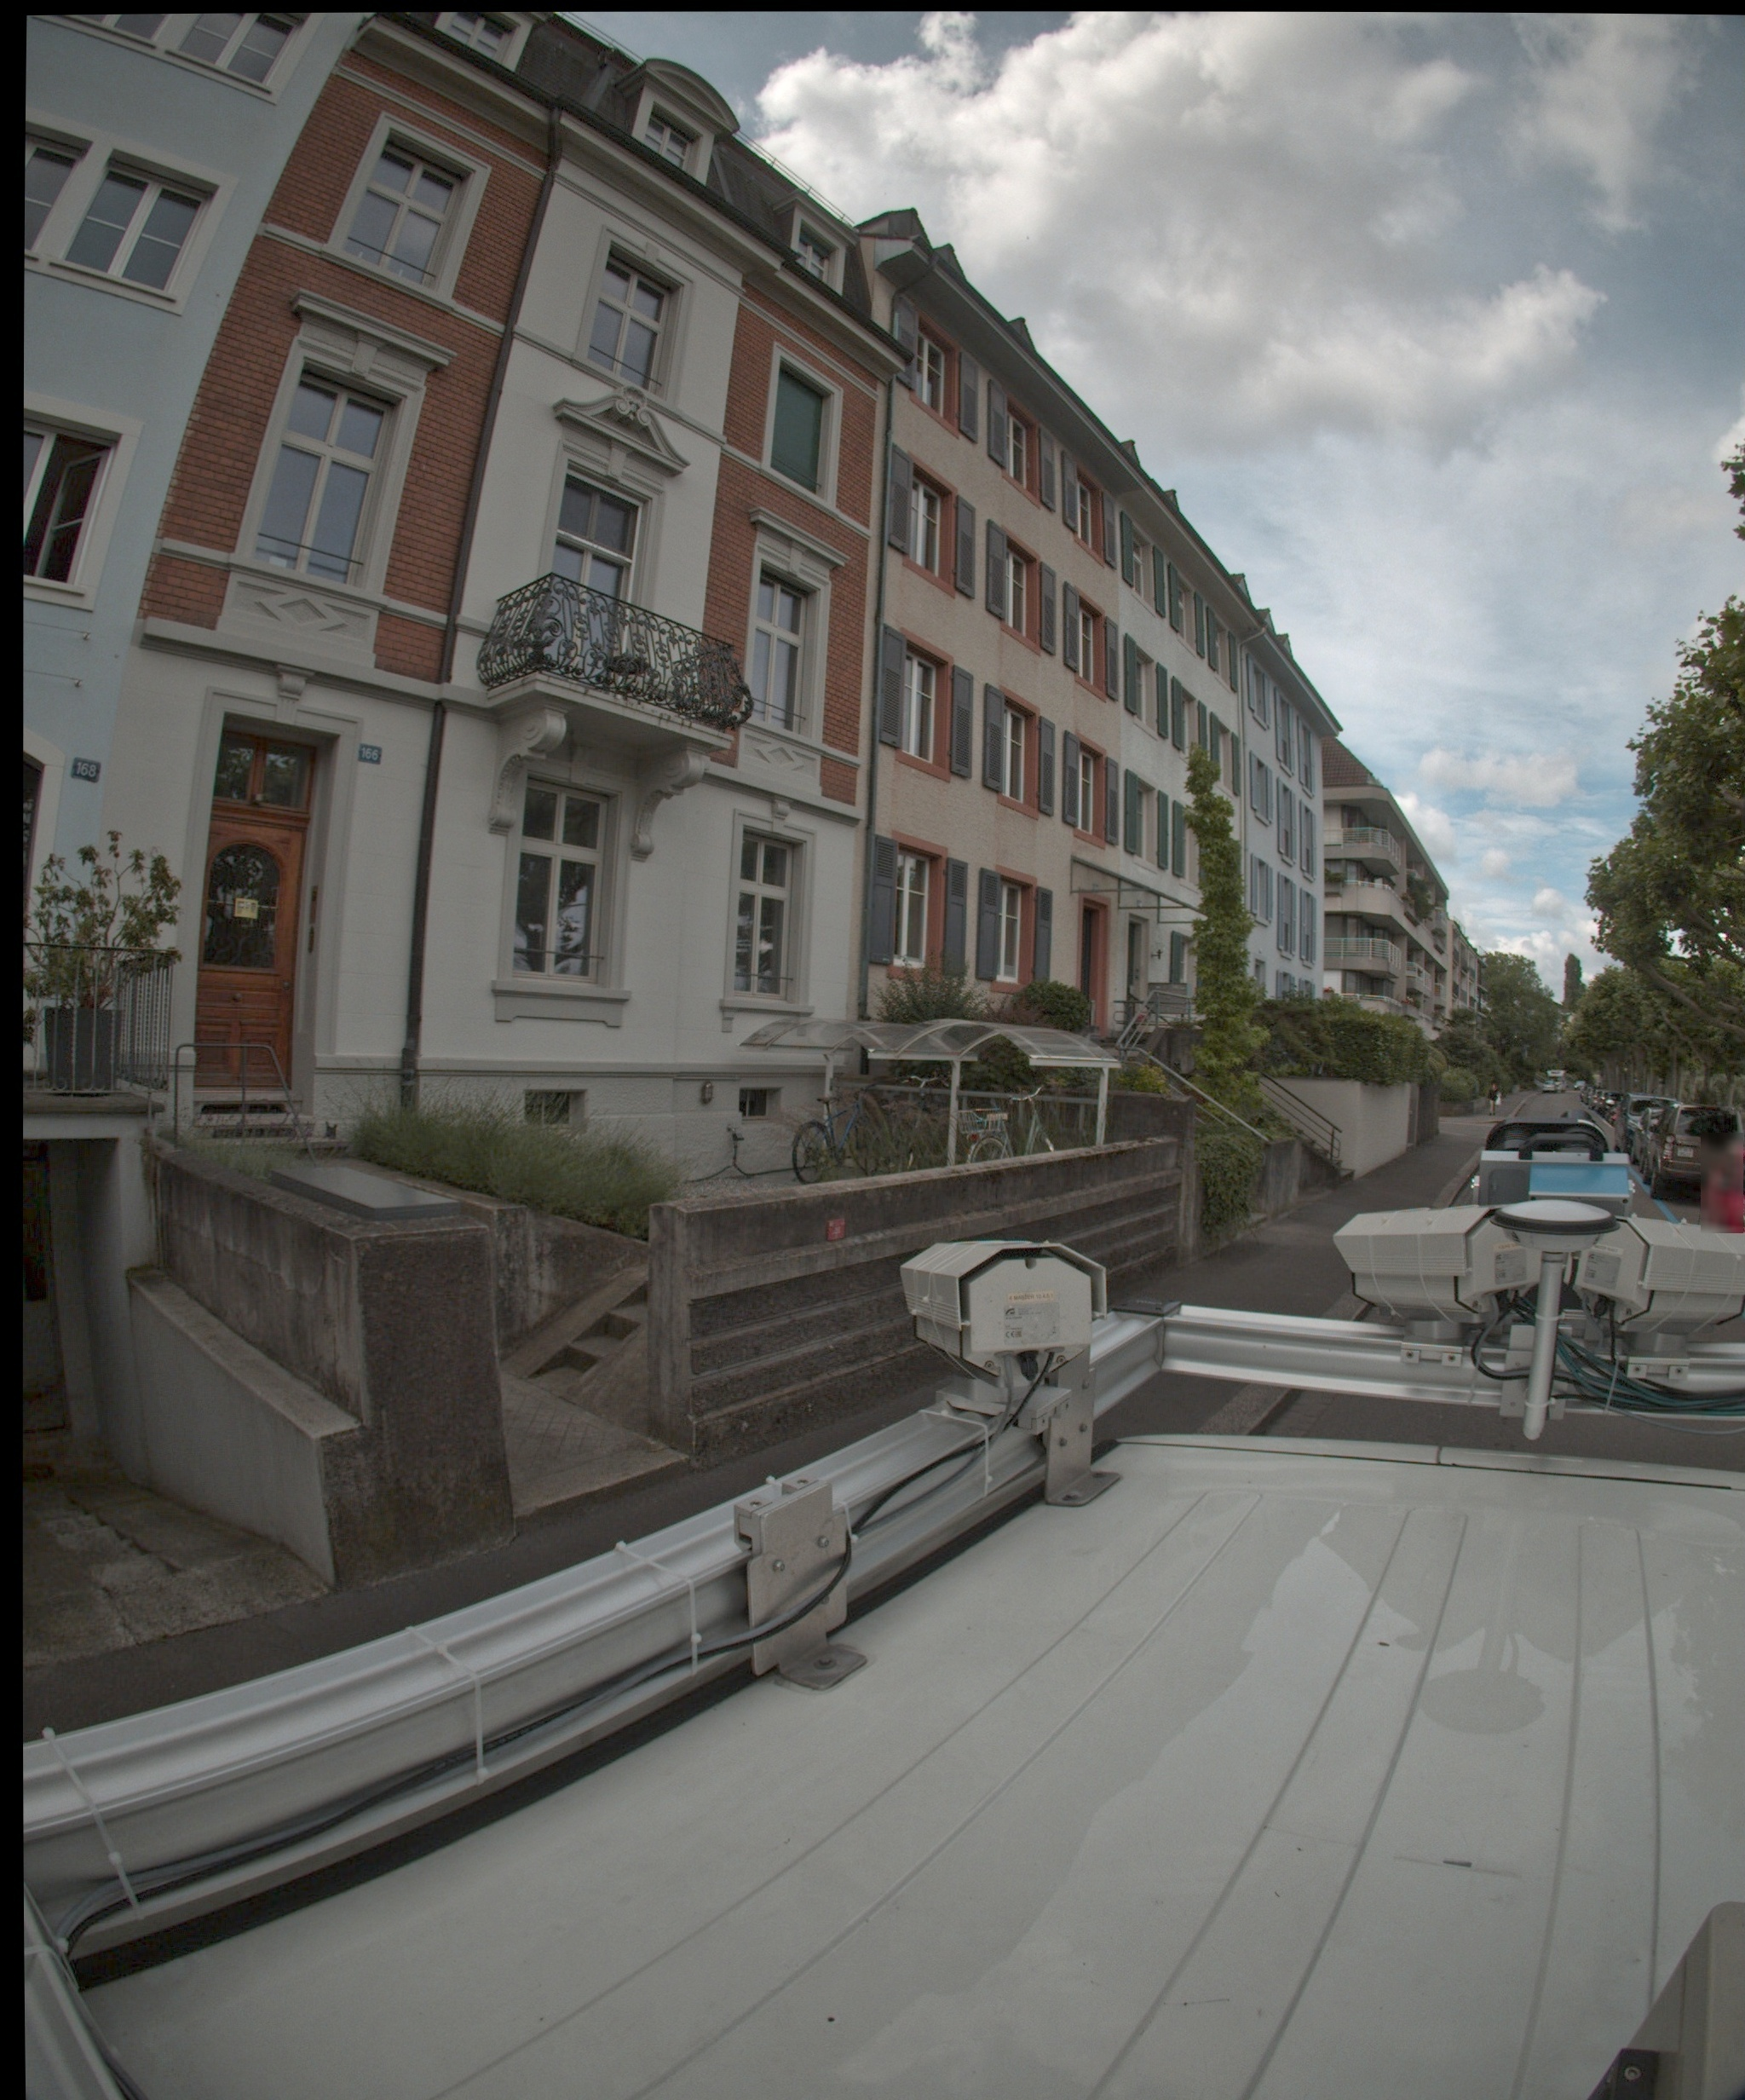

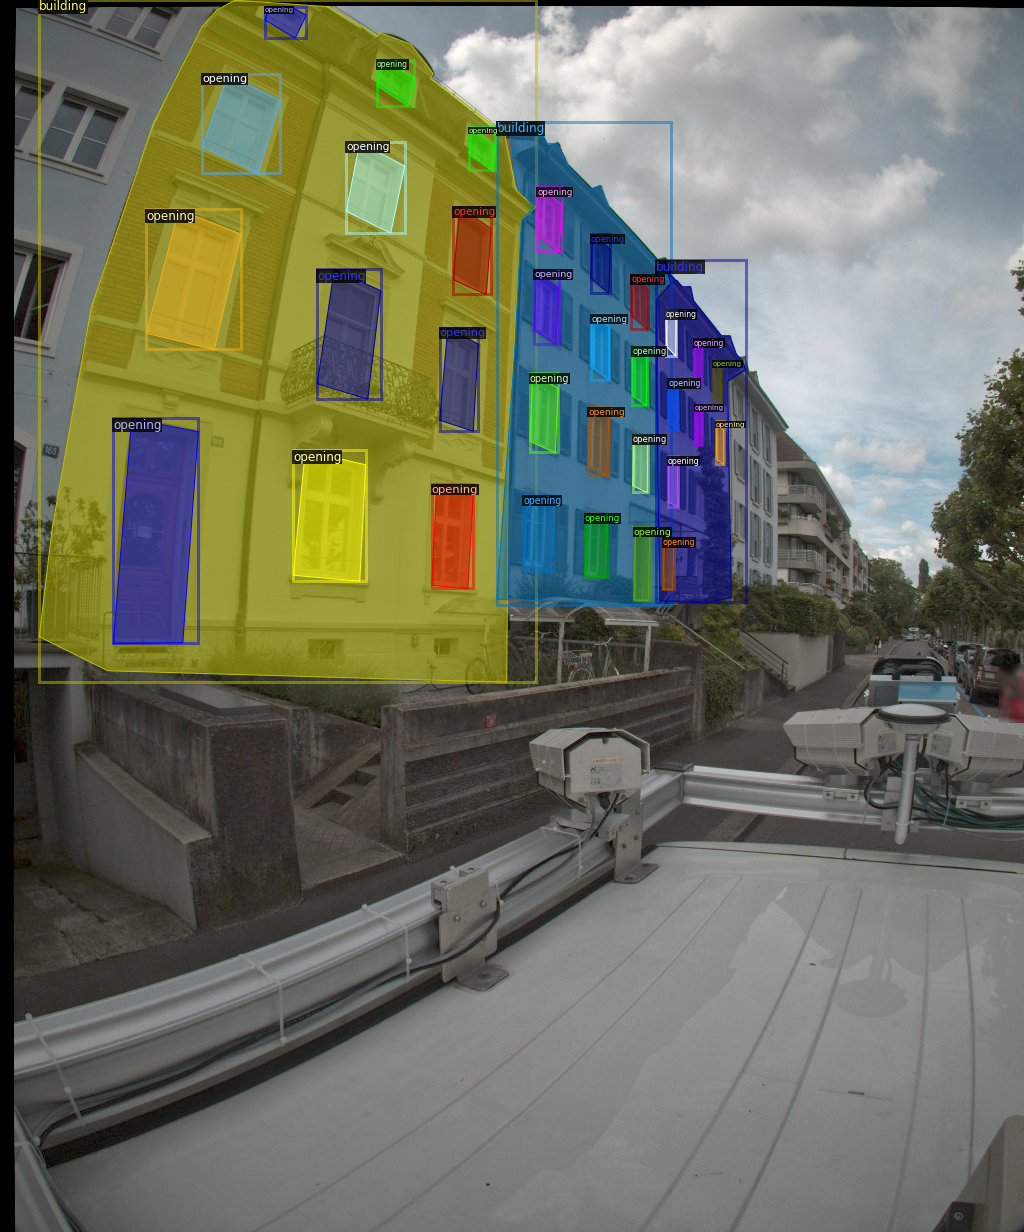

In [8]:
dataset_dicts = get_building_dicts(DATASET_ADDRESS+'/train')
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    cv2_imshow(img)
    visualizer = Visualizer(img[:, :, ::-1], metadata=building_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

## Train

Now, fine-tune a cityscape-pretrained R50-FPN Mask R-CNN model on the building dataset.


In [ ]:
# show GPU info
! /opt/bin/nvidia-smi

Thu Aug  5 21:43:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

There is no epoch parameter in this frame, but it provides IMS_PER_BATCH and MAX_ITER. We can calculate epoch from equation below:

$$ Epoch = MAX\_ITER * IMS\_PER\_BATCH  / TOTAL\_NUM\_IMAGES 
$$

In [ ]:
from detectron2.engine import DefaultTrainer

# here is the parametes we can change for training
EPOCH = 40
TOTAL_NUM_IMAGES = 87

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("building_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = int(EPOCH*TOTAL_NUM_IMAGES/cfg.SOLVER.IMS_PER_BATCH-1)     # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # 2 class ("opening","masonry","m6","rcw"). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[08/05 21:44:04 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

FileNotFoundError: ignored

In [ ]:
# Add validation loss 
from detectron2.engine import HookBase
from detectron2.data import build_detection_train_loader
import detectron2.utils.comm as comm

cfg.DATASETS.VAL = ("building_val",)

class ValidationLoss(HookBase):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg.clone()
        self.cfg.DATASETS.TRAIN = cfg.DATASETS.VAL
        self._loader = iter(build_detection_train_loader(self.cfg))
        
    def after_step(self):
        data = next(self._loader)
        with torch.no_grad():
            loss_dict = self.trainer.model(data)
            
            losses = sum(loss_dict.values())
            assert torch.isfinite(losses).all(), loss_dict

            loss_dict_reduced = {"val_" + k: v.item() for k, v in 
                                 comm.reduce_dict(loss_dict).items()}
            losses_reduced = sum(loss for loss in loss_dict_reduced.values())
            if comm.is_main_process():
                self.trainer.storage.put_scalars(total_val_loss=losses_reduced, 
                                                 **loss_dict_reduced)

In [ ]:
from detectron2.engine import DefaultTrainer
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
val_loss = ValidationLoss(cfg)  
trainer.register_hooks([val_loss])
# swap the order of PeriodicWriter and ValidationLoss
trainer._hooks = trainer._hooks[:-2] + trainer._hooks[-2:][::-1]
trainer.resume_or_load(resume=False)
trainer.train()

[05/03 20:15:50 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:09, 19.7MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to i

[05/03 20:16:08 d2.engine.train_loop]: Starting training from iteration 0
[05/03 20:16:26 d2.utils.events]:  eta: 0:15:14  iter: 19  total_loss: 5.482  loss_cls: 1.105  loss_box_reg: 0.0757  loss_mask: 0.6997  loss_rpn_cls: 3.229  loss_rpn_loc: 0.3349  total_val_loss: 4.783  val_loss_cls: 1.101  val_loss_box_reg: 0.0925  val_loss_mask: 0.6994  val_loss_rpn_cls: 2.755  val_loss_rpn_loc: 0.1902  time: 0.5384  data_time: 0.0679  lr: 4.9953e-06  max_mem: 2219M
[05/03 20:16:43 d2.utils.events]:  eta: 0:15:21  iter: 39  total_loss: 3.856  loss_cls: 1.035  loss_box_reg: 0.09011  loss_mask: 0.6907  loss_rpn_cls: 1.613  loss_rpn_loc: 0.2595  total_val_loss: 3.744  val_loss_cls: 1.046  val_loss_box_reg: 0.2596  val_loss_mask: 0.6898  val_loss_rpn_cls: 1.563  val_loss_rpn_loc: 0.1816  time: 0.5406  data_time: 0.0224  lr: 9.9902e-06  max_mem: 2219M
[05/03 20:17:00 d2.utils.events]:  eta: 0:15:08  iter: 59  total_loss: 3.001  loss_cls: 0.9453  loss_box_reg: 0.4096  loss_mask: 0.6751  loss_rpn_cls: 

In [ ]:
# Look at training and val curves in tensorboard
%load_ext tensorboard
%tensorboard --logdir output

Here it do need train the model again. We use the saved model weights

### Download the weight

In [ ]:
!zip -r /content/weight.zip /content/ouput 

from google.colab import files
files.download("/content/weight.zip") 

## Inference on validation set using the trained model
Now, let's run inference with the trained model on the building validation dataset. First, let's create a predictor using the model we just trained:



In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.80   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

In [ ]:
if not os.path.exists('/content/val_predict'):
  os.makedirs('/content/val_predict')

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_building_dicts(DATASET_ADDRESS+"/val")
# From here to change the numer of imgs to show
# num_to_show = 1
# for d in random.sample(dataset_dicts,num_to_show):  
for d in dataset_dicts:
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=building_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    img_name = 'predict_'+d["file_name"].split('/')[-1]
    savepath = '/content/val_predict/' + img_name
    cv2.imwrite(savepath, out.get_image()[:, :, ::-1])
    cv2_imshow(out.get_image()[:, :, ::-1])

We can also evaluate its performance using AP metric implemented in COCO API.

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("building_val", ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "building_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[05/03 20:42:12 d2.evaluation.coco_evaluation]: 'building_val' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[05/03 20:42:12 d2.data.datasets.coco]: Converting annotations of dataset 'building_val' to COCO format ...)
[05/03 20:42:14 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[05/03 20:42:14 d2.data.datasets.coco]: Conversion finished, #images: 18, #annotations: 476
[05/03 20:42:14 d2.data.datasets.coco]: Caching COCO format annotations at './output/building_val_coco_format.json' ...
[05/03 20:42:15 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/03 20:42:15 d2.data.common]: Serializing 18 elements to byte tensors and concatenating them all ...
[05/03 20:42:15 d2.data.common]: Serialized dataset takes 0.09 MiB
[05/03 20:42:15 d2.evaluation.evaluator]: Start inference on 18 images
[05/03 20:42:32